In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import zscore, shapiro
import statsmodels.api as sm
import pickle
import json
%matplotlib inline

### Problem Statement

### Data Gathering

In [54]:
df = pd.read_csv("medical_insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### Exploratory data analysis

### 1. statastical information

In [55]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### 2. missing values information

In [56]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### 3. dataframe information

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### 4. Outlier information

<AxesSubplot:>

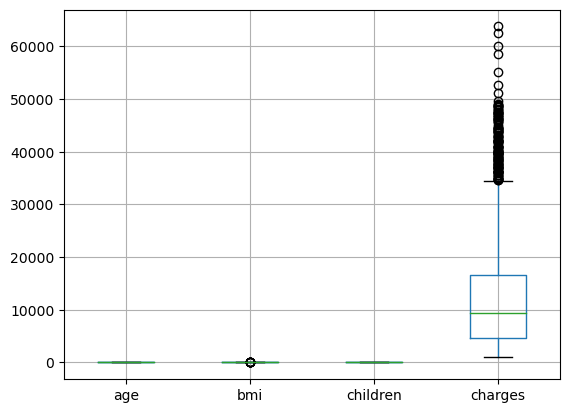

In [58]:
df.boxplot()

### age

<AxesSubplot:xlabel='age'>

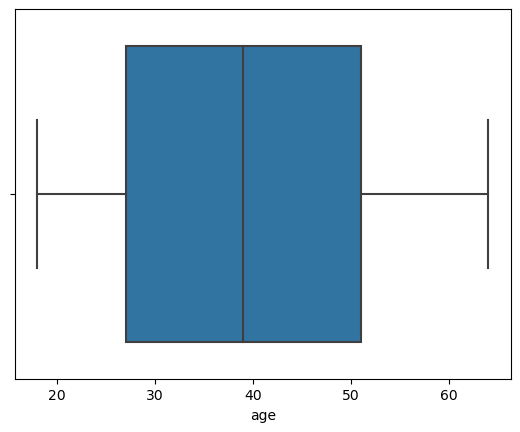

In [59]:
sns.boxplot(df["age"])

### bmi

<AxesSubplot:xlabel='bmi'>

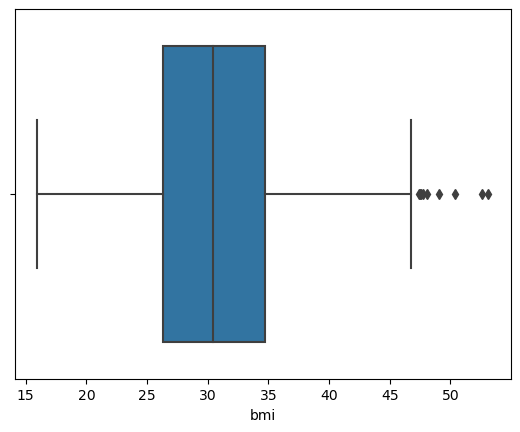

In [60]:
sns.boxplot(df["bmi"])

In [61]:
q1 = df["bmi"].quantile(0.25)
q2 = df["bmi"].quantile(0.50)
q3 = df["bmi"].quantile(0.75)

iqr = q3 - q1

bmi_upper_tail = q3 + 1.5 * iqr
bmi_lower_tail = q1 - 1.5 * iqr

print("q1 =", q1)
print("q2 =", q2)
print("q3 =", q3)
print("iqr =", iqr)
print("upper_tail =", bmi_upper_tail)
print("lower_tail =", bmi_lower_tail)

q1 = 26.29625
q2 = 30.4
q3 = 34.69375
iqr = 8.3975
upper_tail = 47.290000000000006
lower_tail = 13.7


In [62]:
#uppertail outliers
df[["bmi"]].loc[df["bmi"] > bmi_upper_tail]

,bmi
116,49.06
286,48.07
401,47.52
543,47.41
847,50.38
860,47.60
1047,52.58
1088,47.74
1317,53.13


In [63]:
#lowertail outliers
df[["bmi"]].loc[df["bmi"] < bmi_lower_tail]

,bmi


### children

<AxesSubplot:xlabel='children'>

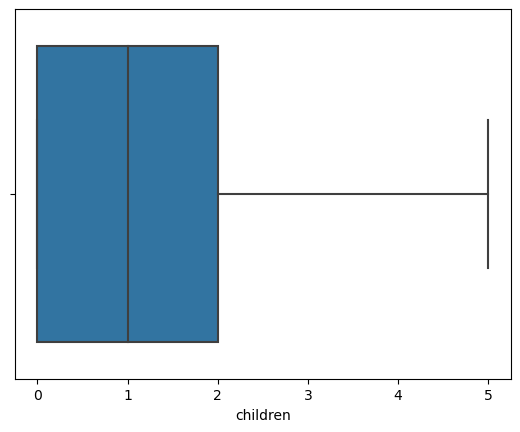

In [64]:
sns.boxplot(df["children"])

### Feature Engineering

### Converting object data into numeric data

### 1. age

In [65]:
df["age"].value_counts().head(5)

18    69
19    68
50    29
51    29
47    29
Name: age, dtype: int64

### 2. sex

In [66]:
df["sex"].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [67]:
df.replace({"male":0, "female":1}, inplace=True)

In [68]:
sex_value = {"male":0, "female":1}
sex_value

{'male': 0, 'female': 1}

### 3. bmi

In [69]:
df["bmi"].value_counts()

32.300    13
28.310     9
30.495     8
30.875     8
31.350     8
          ..
46.200     1
23.800     1
44.770     1
32.120     1
30.970     1
Name: bmi, Length: 548, dtype: int64

### 4. children

In [70]:
df["children"].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

### 5. smoker

In [71]:
df["smoker"].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [72]:
df.replace({"no":0, "yes":1}, inplace=True)

In [73]:
smoker_value = {"no":0, "yes":1}
smoker_value

{'no': 0, 'yes': 1}

### 6. region

In [74]:
df["region"].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [75]:
df = pd.get_dummies(df, columns = ["region"])

### 7. charges

In [76]:
df["charges"].value_counts()

1639.56310     2
16884.92400    1
29330.98315    1
2221.56445     1
19798.05455    1
              ..
7345.08400     1
26109.32905    1
28287.89766    1
1149.39590     1
29141.36030    1
Name: charges, Length: 1337, dtype: int64

### Outliers Imputation

### bmi

In [77]:
bmi_median = df["bmi"].loc[(df["bmi"] <= bmi_upper_tail)].median()
bmi_median

30.3

In [78]:
df.loc[(df["bmi"] > bmi_upper_tail), "bmi"] = bmi_median

In [79]:
df.loc[(df["bmi"] > bmi_upper_tail), "bmi"] 

Series([], Name: bmi, dtype: float64)

### Feature Selection

### 1. Linearity

In [80]:
df.corr()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
age,1.000000,0.020856,0.114273,0.042469,-0.025019,0.299008,0.002475,-0.000407,-0.011642,0.010016
sex,0.020856,1.000000,-0.039736,-0.017163,-0.076185,-0.057292,0.002425,0.011156,-0.017117,0.004184
bmi,0.114273,-0.039736,1.000000,0.017377,-0.002943,0.190559,-0.135819,-0.128304,0.253677,0.000733
children,0.042469,-0.017163,0.017377,1.000000,0.007673,0.067998,-0.022808,0.024806,-0.023066,0.021914
smoker,-0.025019,-0.076185,-0.002943,0.007673,1.000000,0.787251,0.002811,-0.036945,0.068498,-0.036945
charges,0.299008,-0.057292,0.190559,0.067998,0.787251,1.000000,0.006349,-0.039905,0.073982,-0.043210
region_northeast,0.002475,0.002425,-0.135819,-0.022808,0.002811,0.006349,1.000000,-0.320177,-0.345561,-0.320177
region_northwest,-0.000407,0.011156,-0.128304,0.024806,-0.036945,-0.039905,-0.320177,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,-0.017117,0.253677,-0.023066,0.068498,0.073982,-0.345561,-0.346265,1.000000,-0.346265
region_southwest,0.010016,0.004184,0.000733,0.021914,-0.036945,-0.043210,-0.320177,-0.320829,-0.346265,1.000000


<AxesSubplot:>

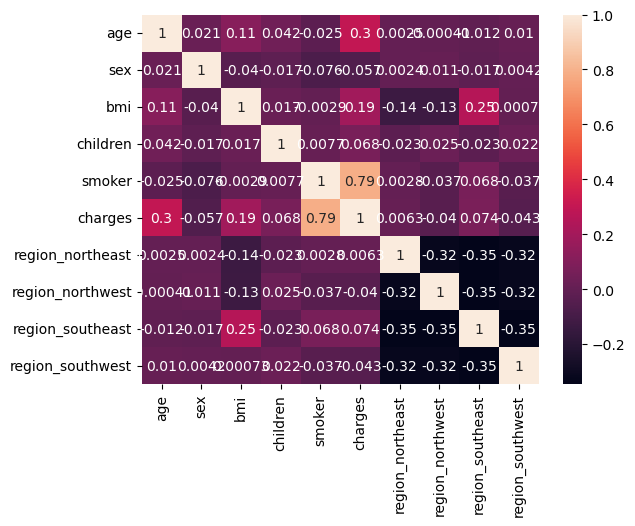

In [81]:
sns.heatmap(df.corr(), annot=True)


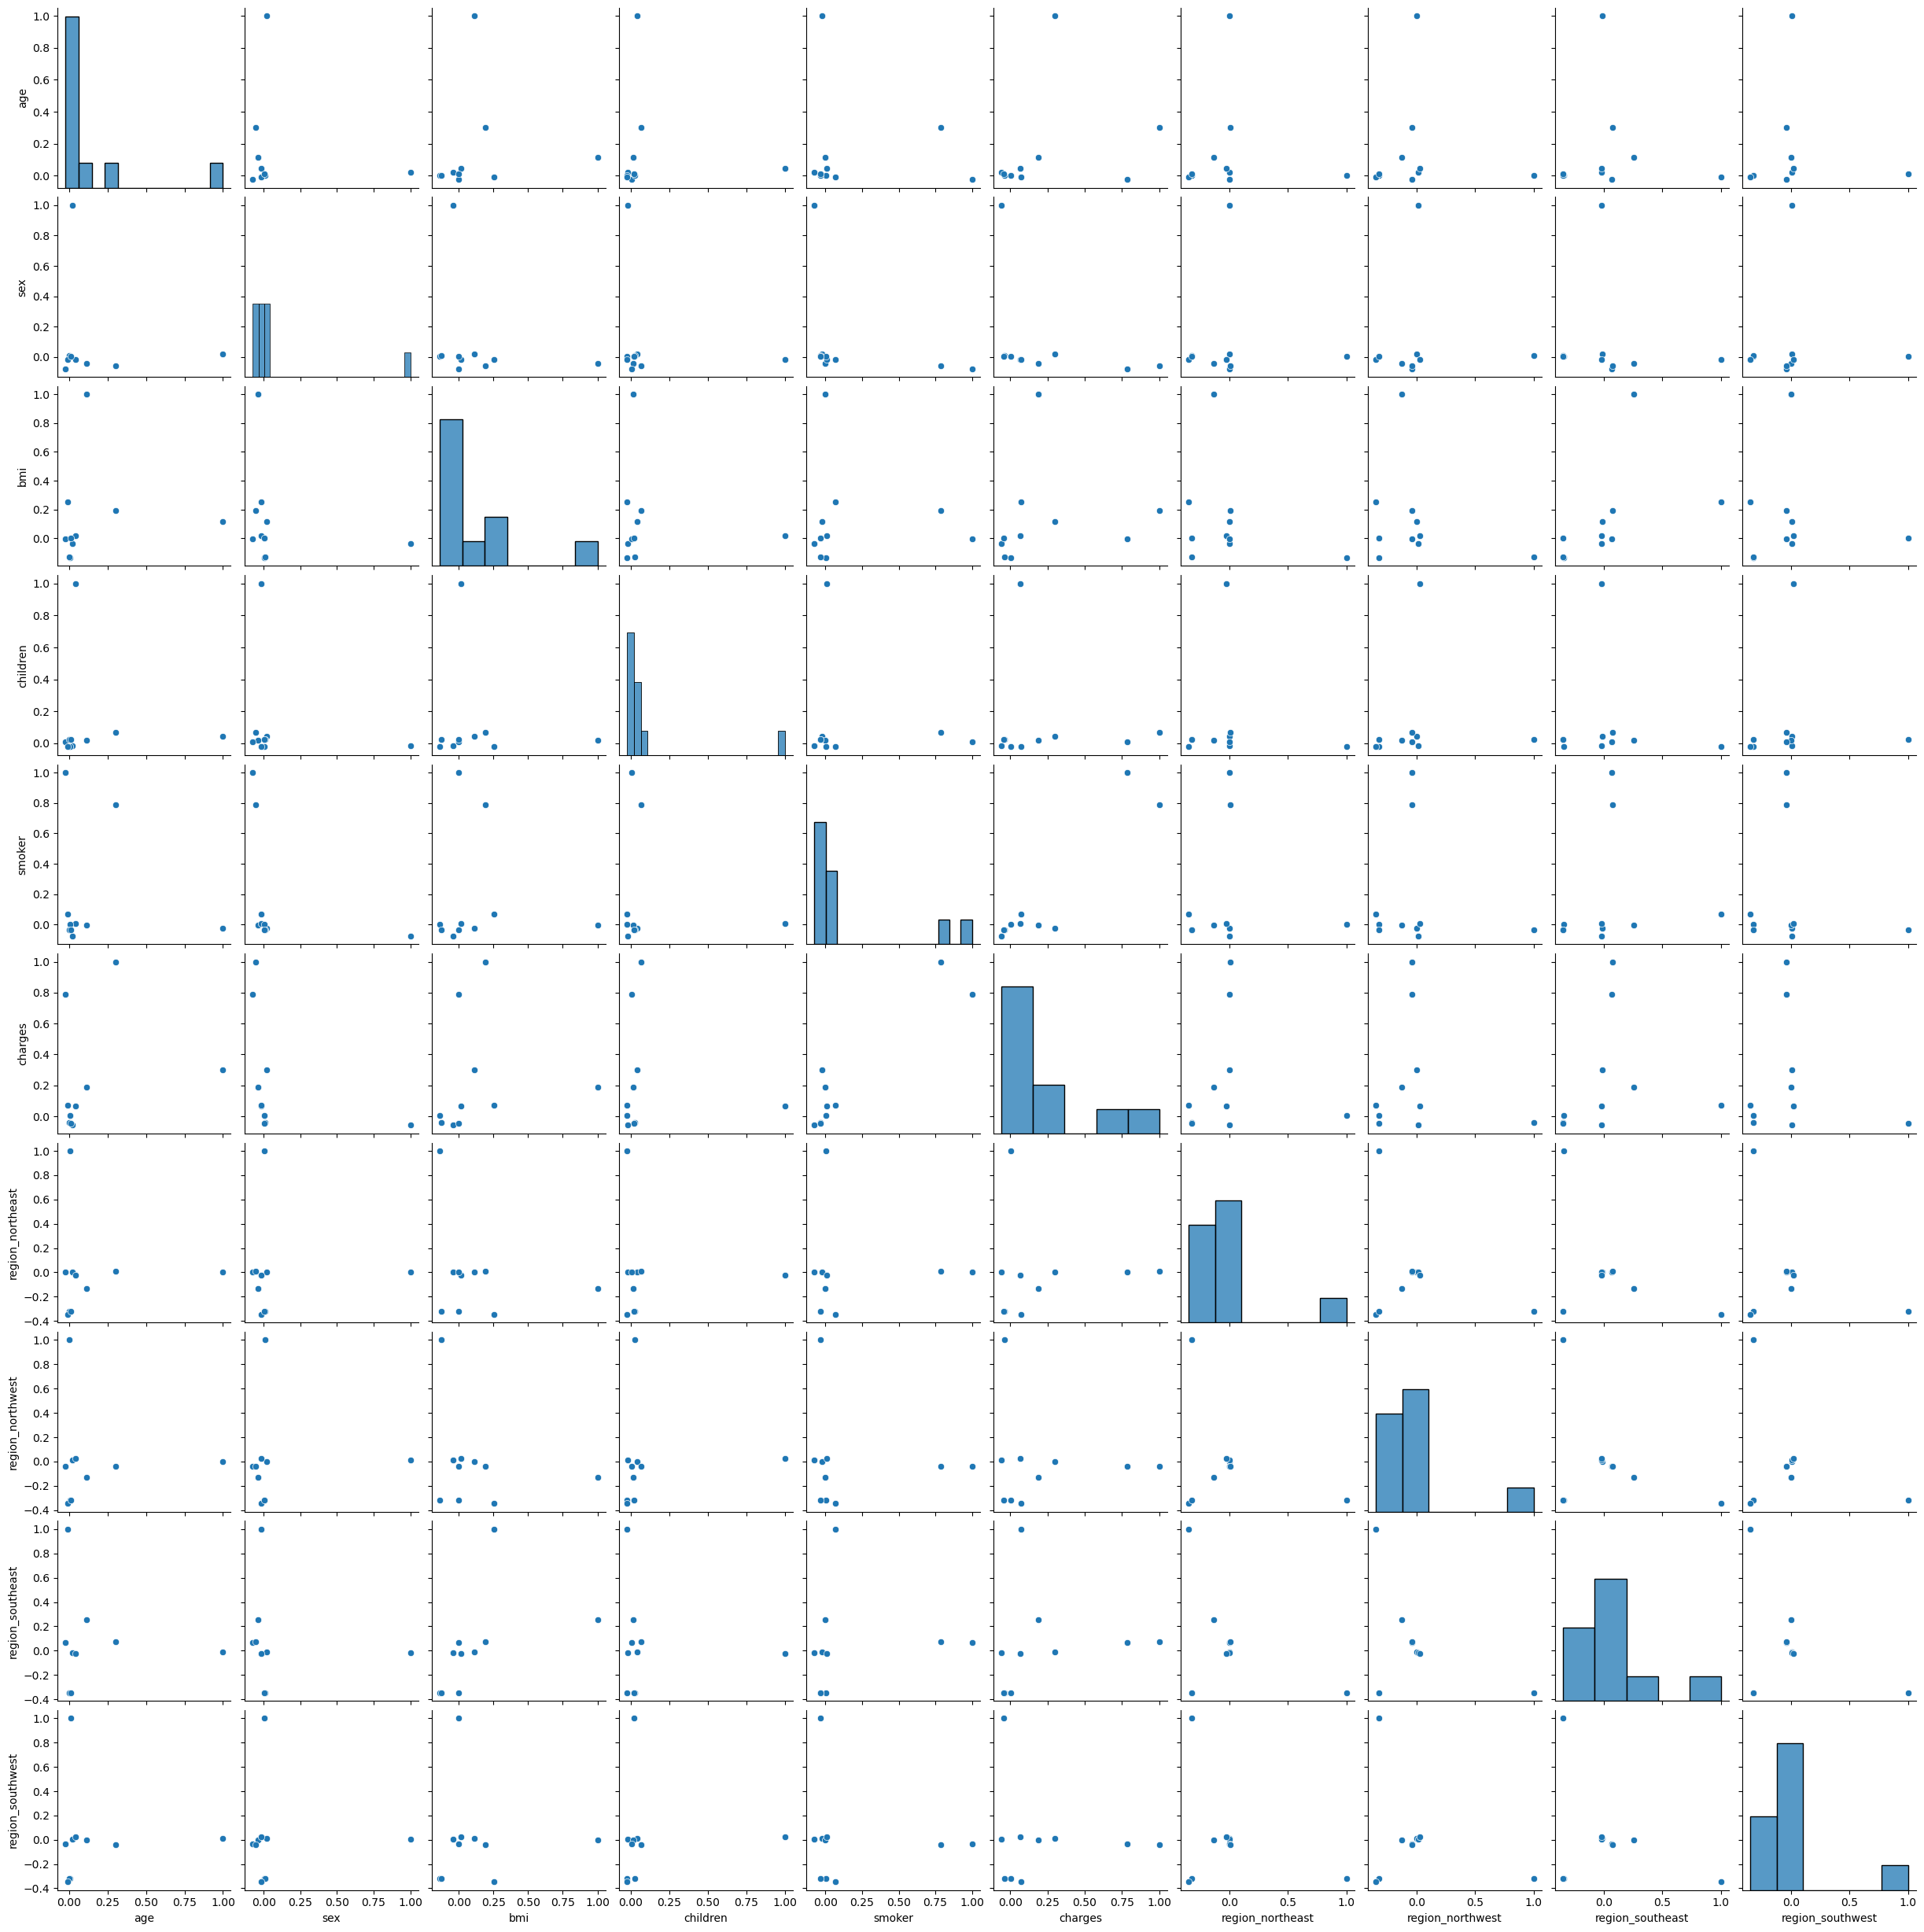

In [82]:
sns.pairplot(df.corr())

### 2. No Multicolinearity

In [83]:
df1 = df.drop("charges", axis=1)

<AxesSubplot:>

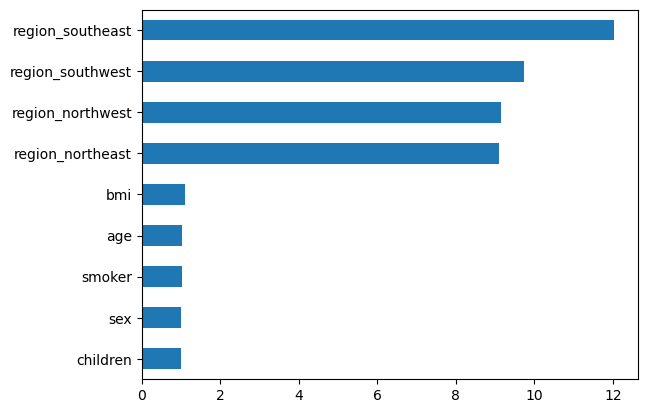

In [84]:
vif_list = []
for i in range(df1.shape[1]):
    vif = variance_inflation_factor(df1, i)
    vif_list.append(vif)
s1 = pd.Series(vif_list, index = df1.columns)
s1.sort_values().plot(kind="barh")

### Model Building

### train test split

In [85]:
x = df.drop("charges", axis=1)
y = df["charges"]

In [86]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
display("x_train", x_train)
display("x_test", x_test)
display("y_train", y_train)
display("y_test", y_test)


'x_train'

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
355,46,0,27.600,0,0,0,0,0,1
1316,19,1,20.600,0,0,0,0,0,1
133,19,0,25.555,0,0,0,1,0,0
181,18,1,38.280,0,0,0,0,1,0
1133,52,1,18.335,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
715,60,0,28.900,0,0,0,0,0,1
905,26,1,29.355,2,0,1,0,0,0
1096,51,1,34.960,2,1,1,0,0,0
235,40,1,22.220,2,1,0,0,1,0


'x_test'

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
559,19,0,35.530,0,0,0,1,0,0
1087,57,0,31.540,0,0,0,1,0,0
1020,51,0,37.000,0,0,0,0,0,1
460,49,1,36.630,3,0,0,0,1,0
802,21,0,22.300,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
120,44,0,37.100,2,0,0,0,0,1
759,18,0,38.170,0,1,0,0,1,0
248,19,0,20.900,1,0,0,0,0,1
991,38,1,27.835,2,0,1,0,0,0


'y_train'

355     24603.04837
1316     1731.67700
133      1632.56445
181      1631.82120
1133     9991.03765
           ...     
715     12146.97100
905      4564.19145
1096    44641.19740
235     19444.26580
1061    11554.22360
Name: charges, Length: 1204, dtype: float64

'y_test'

559      1646.42970
1087    11353.22760
1020     8798.59300
460     10381.47870
802      2103.08000
           ...     
120      7740.33700
759     36307.79830
248      1832.09400
991      7144.86265
1118    38282.74950
Name: charges, Length: 134, dtype: float64

### Linear Regression

### creating instance

In [87]:
linear_reg_model = LinearRegression()

### model training

In [88]:
linear_reg_model.fit(x_train, y_train)

LinearRegression()

### Model Evaluation

In [89]:
#prediction for training data

y_pred_train = linear_reg_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred_train)
print("mse =", mse)

rmse = np.sqrt(mse)
print("rmse =", rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("mae =", mae)

r2 =linear_reg_model.score(x_train, y_train)
print("r2 =", r2)

mse = 36041524.97382318
rmse = 6003.459417187992
mae = 4116.975663302548
r2 = 0.7514585840493561


In [90]:
#prediction for testing data

y_pred = linear_reg_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("mse =", mse)

rmse = np.sqrt(mse)
print("rmse =", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("mae =", mae)

r2 =linear_reg_model.score(x_test, y_test)
print("r2 =", r2)

mse = 43025337.12446294
rmse = 6559.370177422748
mae = 4386.340691023014
r2 = 0.727728655228685


### Normality

In [91]:
residuals = y_train - y_pred_train
residuals

355     16296.535480
1316     2522.701595
133       634.262762
181     -2958.104844
1133     2528.715178
            ...     
715      -230.572693
905     -1005.878543
1096     6917.216045
235    -10400.294965
1061      -82.196799
Name: charges, Length: 1204, dtype: float64

<AxesSubplot:xlabel='charges', ylabel='Density'>

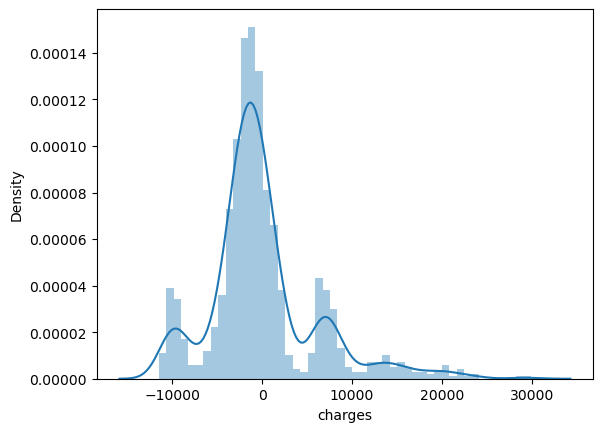

In [92]:
#using distplot for checking normality
sns.distplot(residuals)

In [93]:
#using shapiro test for checking normality
_, p_value = shapiro(residuals)
print(p_value)

if p_value > 0.05:
    print("Null hypothesis is accepted")
    print("data is normally distributed")
else:
    print("Alternate hypothesis is accepted")
    print("data is not normally distributed")

3.9536433604053927e-28
Alternate hypothesis is accepted
data is not normally distributed


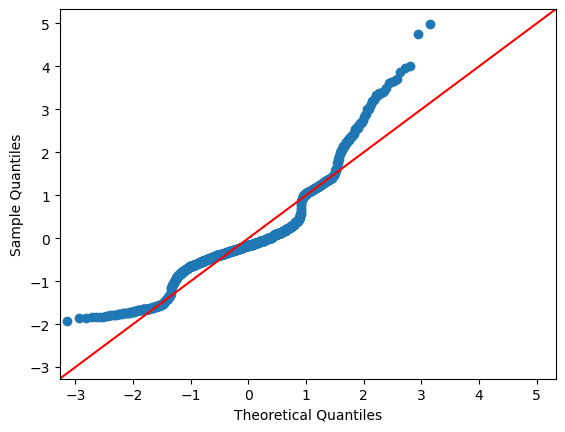

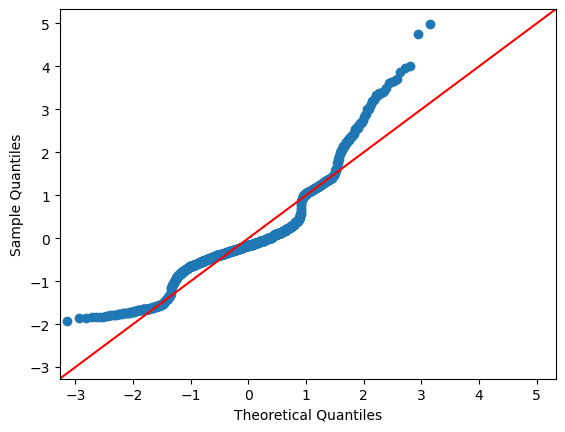

In [94]:
#using qq plot for checking normality
sm.qqplot(residuals, line="45", fit=True)

### Homoscedasticity

<AxesSubplot:xlabel='charges', ylabel='charges'>

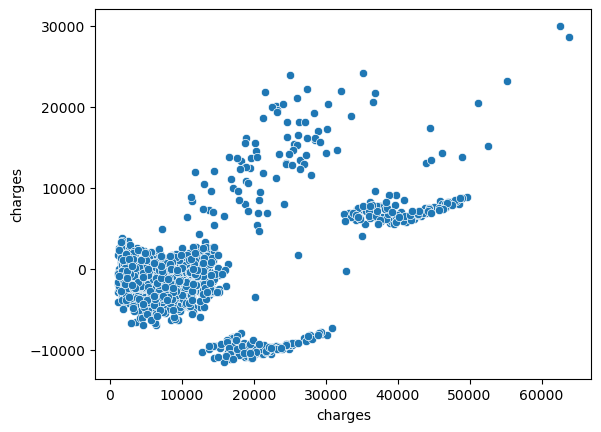

In [95]:
sns.scatterplot(x = y_train, y=residuals)

### Ridge Regression

### creating instance

In [96]:
ridge_reg_model = Ridge(alpha = 0.1)

### model training

In [97]:
ridge_reg_model.fit(x_train, y_train)

Ridge(alpha=0.1)

### Model Evaluation

In [98]:
#prediction for training data

y_pred_train = ridge_reg_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred_train)
print("mse =", mse)

rmse = np.sqrt(mse)
print("rmse =", rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("mae =", mae)

r2 = ridge_reg_model.score(x_train, y_train)
print("r2 =", r2)

mse = 36041549.64096575
rmse = 6003.461471598343
mae = 4117.878226402229
r2 = 0.7514584139453845


In [99]:
#prediction for testing data

y_pred = ridge_reg_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("mse =", mse)

rmse = np.sqrt(mse)
print("rmse =", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("mae =", mae)

r2 = ridge_reg_model.score(x_test, y_test)
print("r2 =", r2)

mse = 43027984.16442174
rmse = 6559.5719497861855
mae = 4387.295235990809
r2 = 0.7277119043284617


### Lasso Regression

### creating instance

In [100]:
lasso_reg_model = Lasso(alpha = 1.0)

### model training

In [101]:
lasso_reg_model.fit(x_train, y_train)

Lasso()

### model evaluation

In [102]:
#prediction for training data

y_pred_train = lasso_reg_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred_train)
print("mse =", mse)

rmse = np.sqrt(mse)
print("rmse =", rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("mae =", mae)

r2 = lasso_reg_model.score(x_train, y_train)
print("r2 =", r2)

mse = 36041554.57342672
rmse = 6003.461882399748
mae = 4117.344542653097
r2 = 0.7514583799312622


In [103]:
#prediction for testing data

y_pred = lasso_reg_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("mse =", mse)

rmse = np.sqrt(mse)
print("rmse =", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("mae =", mae)

r2 = lasso_reg_model.score(x_test, y_test)
print("r2 =", r2)

mse = 43029746.5866476
rmse = 6559.706288138791
mae = 4386.983610293362
r2 = 0.7277007514334105


### Hyper Parameter Tuning

### GridSearchCV for  Ridge Regression

In [104]:
ridge_model = Ridge()
param_grid = {"alpha" : np.arange(0.01,3,0.01)}
gscv_ridge_model = GridSearchCV(ridge_model, param_grid, n_jobs=1)
gscv_ridge_model.fit(x_train, y_train)

GridSearchCV(estimator=Ridge(), n_jobs=1,
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.5...
       2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.3 , 2.31,
       2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.4 , 2.41, 2.42,
       2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5 , 2.51, 2.52, 2.53,
       2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 , 2.61, 2.62, 2.63, 2.64,
       2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71, 2.72, 2.73, 2.74, 2.75,
       2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82, 2.83, 2.84, 2.85, 2.86,
       2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97,
       2.98, 2.99])})

In [105]:
gscv_ridge_model.best_estimator_

Ridge(alpha=0.45)

In [106]:
Ridge_reg_model = Ridge(alpha=0.45)
Ridge_reg_model.fit(x_train, y_train)

Ridge(alpha=0.45)

In [107]:
#prediction on training dataset
y_pred_train = Ridge_reg_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred_train)
print("mse", mse)

rmse = np.sqrt(mse)
print("rmse", rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("mae", mae)

r2 = r2_score(y_train, y_pred_train)
print("r2", r2)

mse 36042022.64853125
rmse 6003.500866039019
mae 4121.029802538018
r2 0.7514551520975528


In [108]:
#prediction on testing dataset
y_pred = Ridge_reg_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("mse", mse)

rmse = np.sqrt(mse)
print("rmse", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("mae", mae)

r2 = r2_score(y_test, y_pred)
print("r2", r2)


mse 43037669.47242243
rmse 6560.310165870394
mae 4390.62826494404
r2 0.7276506141211068


### RandomizedSearchCV for ridge regression

In [109]:
ridge_model = Ridge() 
param_grid = {"alpha": np.arange(0.01,3,0.01)}
rmscv_ridge_model = RandomizedSearchCV(ridge_model, param_grid, n_jobs=1)
rmscv_ridge_model.fit(x_train, y_train)

RandomizedSearchCV(estimator=Ridge(), n_jobs=1,
                   param_distributions={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.5...
       2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.3 , 2.31,
       2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.4 , 2.41, 2.42,
       2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5 , 2.51, 2.52, 2.53,
       2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 , 2.61, 2.62, 2.63, 2.64,
       2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71, 2.72, 2.73, 2.74, 2.75,
       2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82, 2.83, 2.84, 2.85, 2.86,
       2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97,
       2.98, 2.99])})

In [110]:
rmscv_ridge_model.best_estimator_

Ridge(alpha=0.52)

In [111]:
Ridge_reg_model = Ridge(alpha=0.04)
Ridge_reg_model.fit(x_train, y_train)

Ridge(alpha=0.04)

In [112]:
#prediction on training dataset
y_pred_train = Ridge_reg_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred_train)
print("mse", mse)

rmse = np.sqrt(mse)
print("rmse", rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("mae", mae)

r2 = r2_score(y_train, y_pred_train)
print("r2", r2)

mse 36041528.92305948
rmse 6003.459746101366
mae 4117.336801466122
r2 0.7514585568155256


In [113]:
#prediction on testing dataset
y_pred = Ridge_reg_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("mse", mse)

rmse = np.sqrt(mse)
print("rmse", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("mae", mae)

r2 = r2_score(y_test, y_pred)
print("r2", r2)

mse 43026389.50202587
rmse 6559.450396338543
mae 4386.722629322002
r2 0.7277219956119704


### GridSearchCV for Lasso Regression

In [114]:
lasso_model = Lasso()
param_grid = {"alpha": np.arange(0.01,3,0.01)}
gscv_lasso_model = GridSearchCV(ridge_model, param_grid, n_jobs=1)
gscv_lasso_model.fit(x_train, y_train)

GridSearchCV(estimator=Ridge(), n_jobs=1,
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.5...
       2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.3 , 2.31,
       2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.4 , 2.41, 2.42,
       2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5 , 2.51, 2.52, 2.53,
       2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 , 2.61, 2.62, 2.63, 2.64,
       2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71, 2.72, 2.73, 2.74, 2.75,
       2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82, 2.83, 2.84, 2.85, 2.86,
       2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97,
       2.98, 2.99])})

In [115]:
gscv_lasso_model.best_estimator_

Ridge(alpha=0.45)

In [116]:
Lasso_reg_model = Lasso(alpha=0.45)
Lasso_reg_model.fit(x_train, y_train)

Lasso(alpha=0.45)

In [117]:
#prediction on training dataset
y_pred_train = Ridge_reg_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred_train)
print("mse", mse)

rmse = np.sqrt(mse)
print("rmse", rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("mae", mae)

r2 = r2_score(y_train, y_pred_train)
print("r2", r2)

mse 36041528.92305948
rmse 6003.459746101366
mae 4117.336801466122
r2 0.7514585568155256


In [118]:
#prediction on testing dataset
y_pred = Ridge_reg_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("mse", mse)

rmse = np.sqrt(mse)
print("rmse", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("mae", mae)

r2 = r2_score(y_test, y_pred)
print("r2", r2)


mse 43026389.50202587
rmse 6559.450396338543
mae 4386.722629322002
r2 0.7277219956119704


### RandomizedSearchCV for Lasoo Regression

In [119]:
lasso_model = Lasso() 
param_grid = {"alpha": np.arange(0.01,3,0.01)}
rmscv_lasso_model = RandomizedSearchCV(lasso_model, param_grid, n_jobs=1)
rmscv_lasso_model.fit(x_train, y_train)

RandomizedSearchCV(estimator=Lasso(), n_jobs=1,
                   param_distributions={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.5...
       2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.3 , 2.31,
       2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.4 , 2.41, 2.42,
       2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5 , 2.51, 2.52, 2.53,
       2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 , 2.61, 2.62, 2.63, 2.64,
       2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71, 2.72, 2.73, 2.74, 2.75,
       2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82, 2.83, 2.84, 2.85, 2.86,
       2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97,
       2.98, 2.99])})

In [120]:
rmscv_lasso_model.best_estimator_

Lasso(alpha=2.92)

In [121]:
Lasso_reg_model = Lasso(alpha=1.96)
Lasso_reg_model.fit(x_train, y_train)

Lasso(alpha=1.96)

In [122]:
#prediction on training dataset
y_pred_train = Ridge_reg_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred_train)
print("mse", mse)

rmse = np.sqrt(mse)
print("rmse", rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("mae", mae)

r2 = r2_score(y_train, y_pred_train)
print("r2", r2)

mse 36041528.92305948
rmse 6003.459746101366
mae 4117.336801466122
r2 0.7514585568155256


In [123]:
#prediction on testing dataset
y_pred = Ridge_reg_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("mse", mse)

rmse = np.sqrt(mse)
print("rmse", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("mae", mae)

r2 = r2_score(y_test, y_pred)
print("r2", r2)

mse 43026389.50202587
rmse 6559.450396338543
mae 4386.722629322002
r2 0.7277219956119704


### creating pickle file

In [124]:
x.head(1).T

,0
age,19.0
sex,1.0
bmi,27.9
children,0.0
smoker,1.0
region_northeast,0.0
region_northwest,0.0
region_southeast,0.0
region_southwest,1.0


In [125]:
column_names = x.columns
len(column_names)

9

In [126]:
with open("Linear model.pkl", "wb") as f:
    pickle.dump(linear_reg_model, f)

In [127]:
json_data = {"sex":sex_value, 
            "smoker":smoker_value,
            "columns":list(column_names)}
json_data

{'sex': {'male': 0, 'female': 1},
 'smoker': {'no': 0, 'yes': 1},
 'columns': ['age',
  'sex',
  'bmi',
  'children',
  'smoker',
  'region_northeast',
  'region_northwest',
  'region_southeast',
  'region_southwest']}

In [128]:
    with open("Project_data.json", "w") as f:
        json.dump(json_data, f)

# Single user Input Testing

In [129]:
age = 19.0
sex = "female"
bmi = 27.9
children = 0.0
smoker = "no"
region = "northwest"

region = "region_" + region
region

region_index = np.where(column_names == region)[0][0]
region_index

6

In [130]:
region_index = region_index = list(column_names).index(region)
region_index

6

In [131]:
x.shape[1]

9

In [132]:
json_data['columns']

['age',
 'sex',
 'bmi',
 'children',
 'smoker',
 'region_northeast',
 'region_northwest',
 'region_southeast',
 'region_southwest']

In [133]:
test_array = np.zeros(len(column_names))

test_array[0] = age
test_array[1] = json_data['sex'][sex]
test_array[2] = bmi
test_array[3] = children
test_array[4] = json_data['smoker'][smoker]
test_array[region_index] = 1

test_array

array([19. ,  1. , 27.9,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ])

In [134]:
charges = round(linear_reg_model.predict([test_array])[0],2)
print("Predicted Medical Insurance Charges is :", charges, "/- Rs. Only")

Predicted Medical Insurance Charges is : 1978.48 /- Rs. Only


In [135]:
data = dict([('age', '84'), ('sex', 'male'), ('bmi', '24'), ('children', '2'), ('smoker', 'no'), ('region', 'northeast')])
data

{'age': '84',
 'sex': 'male',
 'bmi': '24',
 'children': '2',
 'smoker': 'no',
 'region': 'northeast'}